## Imports and Helper Functions

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import warnings

warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=DeprecationWarning)

In [4]:
def plot_garage_data_over_time(df, feature_to_plot, individual_plots=False):
    # get list of unique garages
    unique_garagecodes = df['garagecode'].unique().tolist()

    if individual_plots:
        # 8 individual plots
        for garage in unique_garagecodes:
            filtered_df = df[df['garagecode'] == garage]

            sns.lineplot(x='update_datetime', y=feature_to_plot, data=filtered_df)
            plt.title(garage)
            plt.show()

    else:
        # 1 plot with 4x2 subplots
        row_count = 4
        col_count = 2

        fig, axes = plt.subplots(nrows=row_count, ncols=col_count, figsize=(12,16))

        for i, garage in enumerate(unique_garagecodes):
            row = i // col_count
            col = i % col_count
            filtered_df = df[df['garagecode'] == garage]

            sns.lineplot(x='update_dt', y=feature_to_plot, data=filtered_df, ax=axes[row, col])
            axes[row, col].set_title(garage)

        plt.suptitle(f'{feature_to_plot} over Time')
        plt.tight_layout()
        plt.show()

## Loading and cleaning data

In [5]:
file = 'aarhus_parking.csv'
df_raw = pd.read_csv(file)

df_raw.head(10)

,vehiclecount,updatetime,_id,totalspaces,garagecode,streamtime
0,0,2014-05-22 09:09:04.145,1,65,NORREPORT,2014-11-03 16:18:44
1,0,2014-05-22 09:09:04.145,2,512,SKOLEBAKKEN,2014-11-03 16:18:44
2,869,2014-05-22 09:09:04.145,3,1240,SCANDCENTER,2014-11-03 16:18:44
3,22,2014-05-22 09:09:04.145,4,953,BRUUNS,2014-11-03 16:18:44
4,124,2014-05-22 09:09:04.145,5,130,BUSGADEHUSET,2014-11-03 16:18:44
5,106,2014-05-22 09:09:04.145,6,400,MAGASIN,2014-11-03 16:18:44
6,115,2014-05-22 09:09:04.145,7,210,KALKVAERKSVEJ,2014-11-03 16:18:44
7,233,2014-05-22 09:09:04.145,8,700,SALLING,2014-11-03 16:18:44
8,0,2014-05-22 09:39:01.803,9,65,NORREPORT,2014-11-03 16:18:44
9,0,2014-05-22 09:39:01.803,10,512,SKOLEBAKKEN,2014-11-03 16:18:44


In [6]:
df_raw.describe()

,vehiclecount,_id,totalspaces
count,55264.000000,55264.000000,55264.000000
mean,192.188387,27667.796468,526.250000
std,210.500021,15959.295617,388.536895
min,0.000000,1.000000,65.000000
25%,32.000000,13855.750000,190.000000
50%,96.000000,27671.500000,456.000000
75%,296.000000,41487.250000,763.250000
max,1464.000000,55303.000000,1240.000000


In [7]:
df_raw.dtypes

vehiclecount     int64
updatetime      object
_id              int64
totalspaces      int64
garagecode      object
streamtime      object
dtype: object

In [8]:
df = df_raw.copy()

As seen above in the dataframe head and description, the '_id' column serves purely as a means to track the updates sent to the main database and is redundant to the data's index.

In [9]:
df = df.drop(columns=['_id'])

### Datetime data

In [10]:
# set time columns to datetimes
df['update_dt'] = pd.to_datetime(df['updatetime'])
df['stream_dt'] = pd.to_datetime(df['streamtime'])

df = df.drop(columns=['updatetime', 'streamtime'])

In [11]:
df[['update_dt', 'stream_dt']].describe()

,update_dt,stream_dt
count,55264,55264
unique,6908,47
top,2014-05-22 09:09:04.145000,2014-11-03 16:18:44
freq,8,10000
first,2014-05-22 09:09:04.145000,2014-11-03 16:18:44
last,2014-11-04 14:13:47.581000,2014-11-04 14:20:03


The streamtime feature tracks only when the data was collected from each garage and sent to the main database, and does not reflect the changing parking capacity of the garages over time. Thus the feature will not be needed for predictive modeling, and will be dropped from the cleaned dataset.

In [12]:
df = df.drop(columns=['stream_dt'])

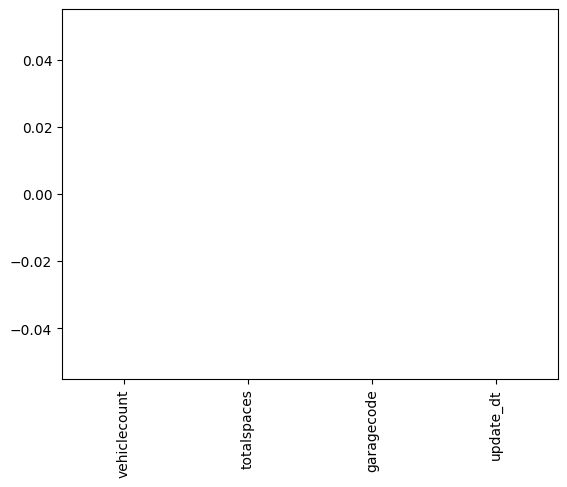

In [13]:
# check for NA values
df.isna().sum().plot.bar()
plt.show()

### Visualize parking data over time at each garage

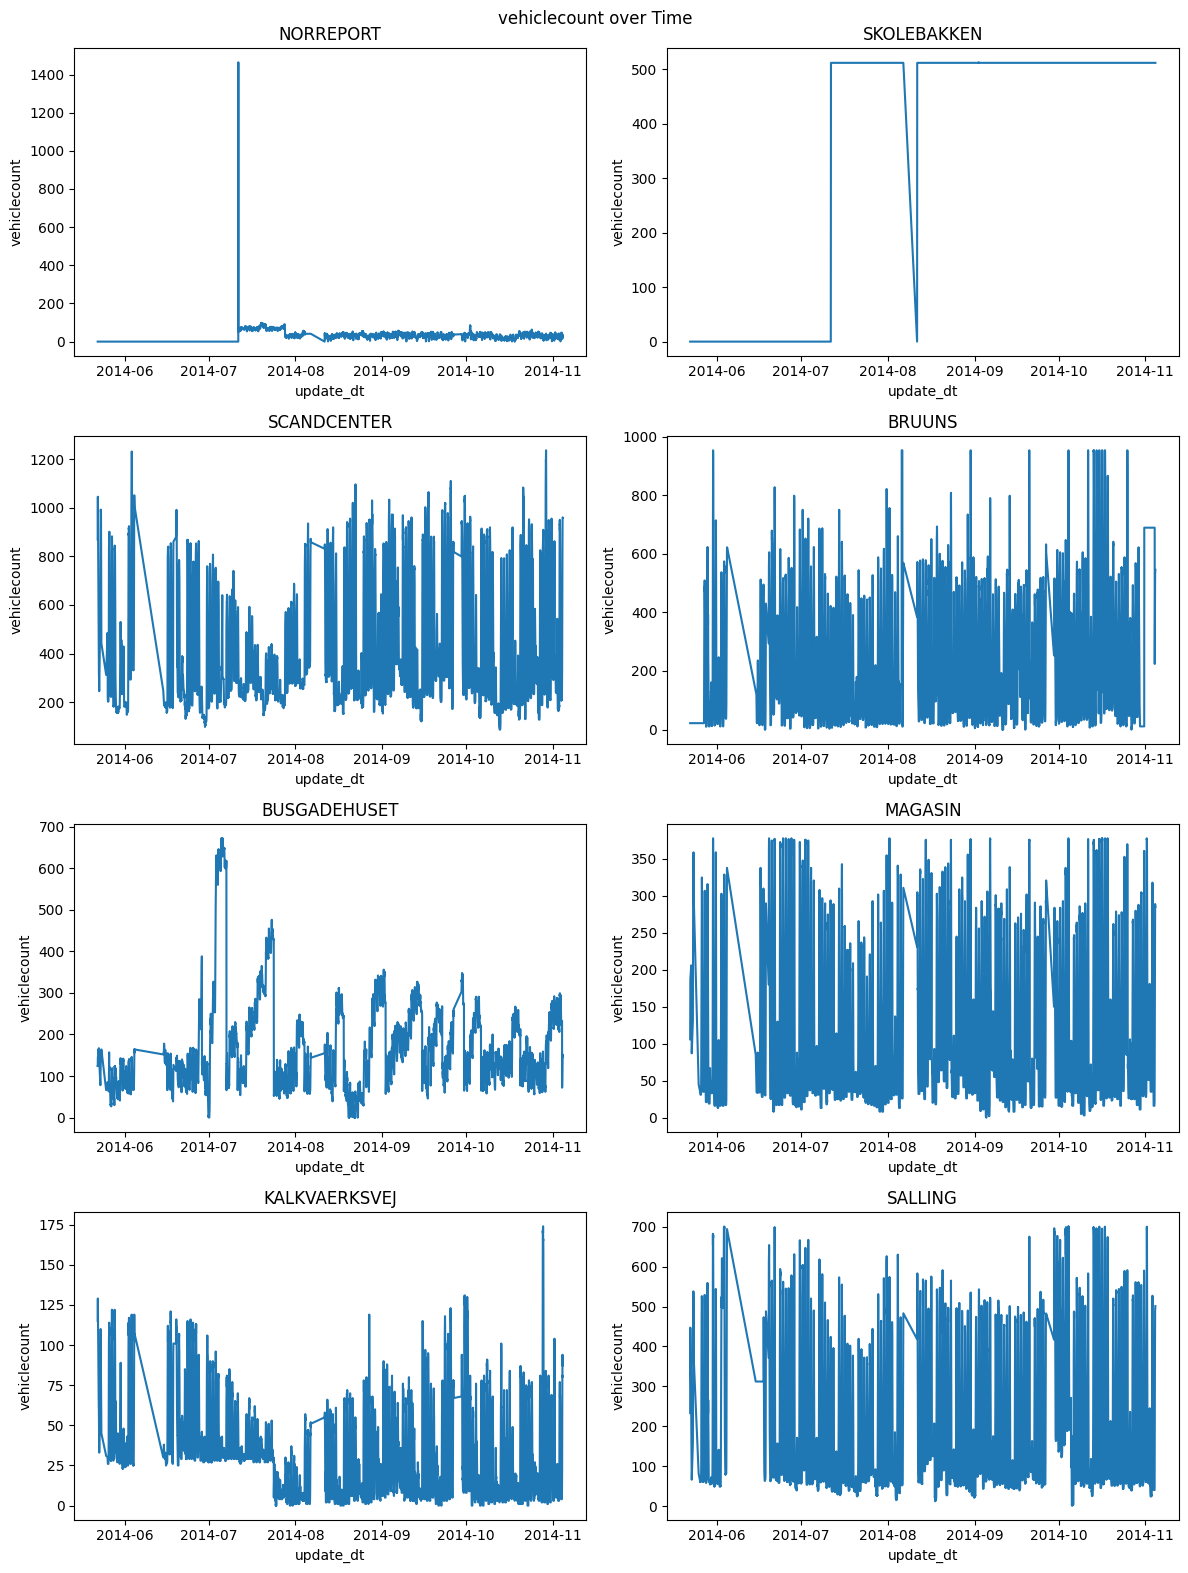

In [14]:
plot_garage_data_over_time(df, 'vehiclecount', individual_plots=False)

The data for garage 'Skolebakken' appears to be inaccurate and will not be useful in training a predictive model. As such, this garage will be dropped from the dataset.  
Additionally, prior to ~ mid July, the garage at Norreport does not appear to be accurately tracking the number of available parking spaces. The data prior to this cutoff, specifically for the Norreport garage, will also be dropped.

In [15]:
# drop skolebakken data
df = df[df['garagecode'] != 'SKOLEBAKKEN']

In [16]:
df[df['garagecode'] == 'NORREPORT'].describe()

,vehiclecount,totalspaces
count,6908.000000,6908.0
mean,29.277794,65.0
std,28.587276,0.0
min,0.000000,65.0
25%,1.000000,65.0
50%,30.000000,65.0
75%,41.000000,65.0
max,1464.000000,65.0


In [17]:
# with the spike in data identified from the .describe() above, we can find the date which the spike occurred
df[df['vehiclecount'] == 1464]

,vehiclecount,totalspaces,garagecode,update_dt
13760,1464,65,NORREPORT,2014-07-11 15:26:49.612


In [18]:
# drop all data points for norreport which occurred prior to 2014-07-12
df = df[(df['garagecode'] != 'NORREPORT') | (df['update_dt'] >= '2014-07-12')]

In [19]:
df.columns

Index(['vehiclecount', 'totalspaces', 'garagecode', 'update_dt'], dtype='object')

## Feature extraction

### Datetime

In [20]:
# extract date and time as individual features
df['date'] = df['update_dt'].dt.date
df['time'] = df['update_dt'].dt.time

In [21]:
# Extracting more from the date
df['date'] = pd.to_datetime(df['date'])
df['weekday'] = df['date'].dt.weekday
df['day'] = df['date'].dt.day
df['month'] = df['date'].dt.month
df['year'] = df['date'].dt.year

The extracted datetime information will be further modified through cyclic encoding. Cyclic encoding can be beneficial within time series modeling and predictions to indicate the cyclic nature of certain features such as the time of day, day of the week or month, or month of the year. Rather than existing on a linear scale, these features occur in a cyclic pattern, and can potentially help a model to better account for patterns occurring over time.

In [22]:
# cyclic encoding of datetime information
df['weekday_sin'] = np.sin(2 * np.pi * df['weekday'] / 7)
df['weekday_cos'] = np.cos(2 * np.pi * df['weekday'] / 7)

df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)

df['day_sin'] = np.sin(2 * np.pi * df['day'] / 31)
df['day_cos'] = np.cos(2 * np.pi * df['day'] / 31)

df['time_sin'] = np.sin(2 * np.pi * (df['time'].apply(lambda x: x.hour) * 60 + df['time'].apply(lambda x: x.minute)) / (24 * 60))
df['time_cos'] = np.cos(2 * np.pi * (df['time'].apply(lambda x: x.hour) * 60 + df['time'].apply(lambda x: x.minute)) / (24 * 60))

### Parking data

The parking data is currently tracked as the number of occupied spaces (vehiclecount), and as the total number of spaces (totalspaces). However, in order to potentially improve model generalization across multiple garages, an additional feature can be extracted, which is the garage's current capacity as a percentage. I.e a garage that is full would have a capacity of 1, and a garage which is empty would have a capacity of 0.

In [23]:
df['capacity'] = df['vehiclecount'] / df['totalspaces']

In [24]:
df.head()

,vehiclecount,totalspaces,garagecode,update_dt,date,time,weekday,day,month,year,weekday_sin,weekday_cos,month_sin,month_cos,day_sin,day_cos,time_sin,time_cos,capacity
2,869,1240,SCANDCENTER,2014-05-22 09:09:04.145,2014-05-22,09:09:04.145000,3,22,5,2014,0.433884,-0.900969,0.5,-0.866025,-0.968077,-0.250653,0.678801,-0.734323,0.700806
3,22,953,BRUUNS,2014-05-22 09:09:04.145,2014-05-22,09:09:04.145000,3,22,5,2014,0.433884,-0.900969,0.5,-0.866025,-0.968077,-0.250653,0.678801,-0.734323,0.023085
4,124,130,BUSGADEHUSET,2014-05-22 09:09:04.145,2014-05-22,09:09:04.145000,3,22,5,2014,0.433884,-0.900969,0.5,-0.866025,-0.968077,-0.250653,0.678801,-0.734323,0.953846
5,106,400,MAGASIN,2014-05-22 09:09:04.145,2014-05-22,09:09:04.145000,3,22,5,2014,0.433884,-0.900969,0.5,-0.866025,-0.968077,-0.250653,0.678801,-0.734323,0.265000
6,115,210,KALKVAERKSVEJ,2014-05-22 09:09:04.145,2014-05-22,09:09:04.145000,3,22,5,2014,0.433884,-0.900969,0.5,-0.866025,-0.968077,-0.250653,0.678801,-0.734323,0.547619


### Visualizing capacity over time

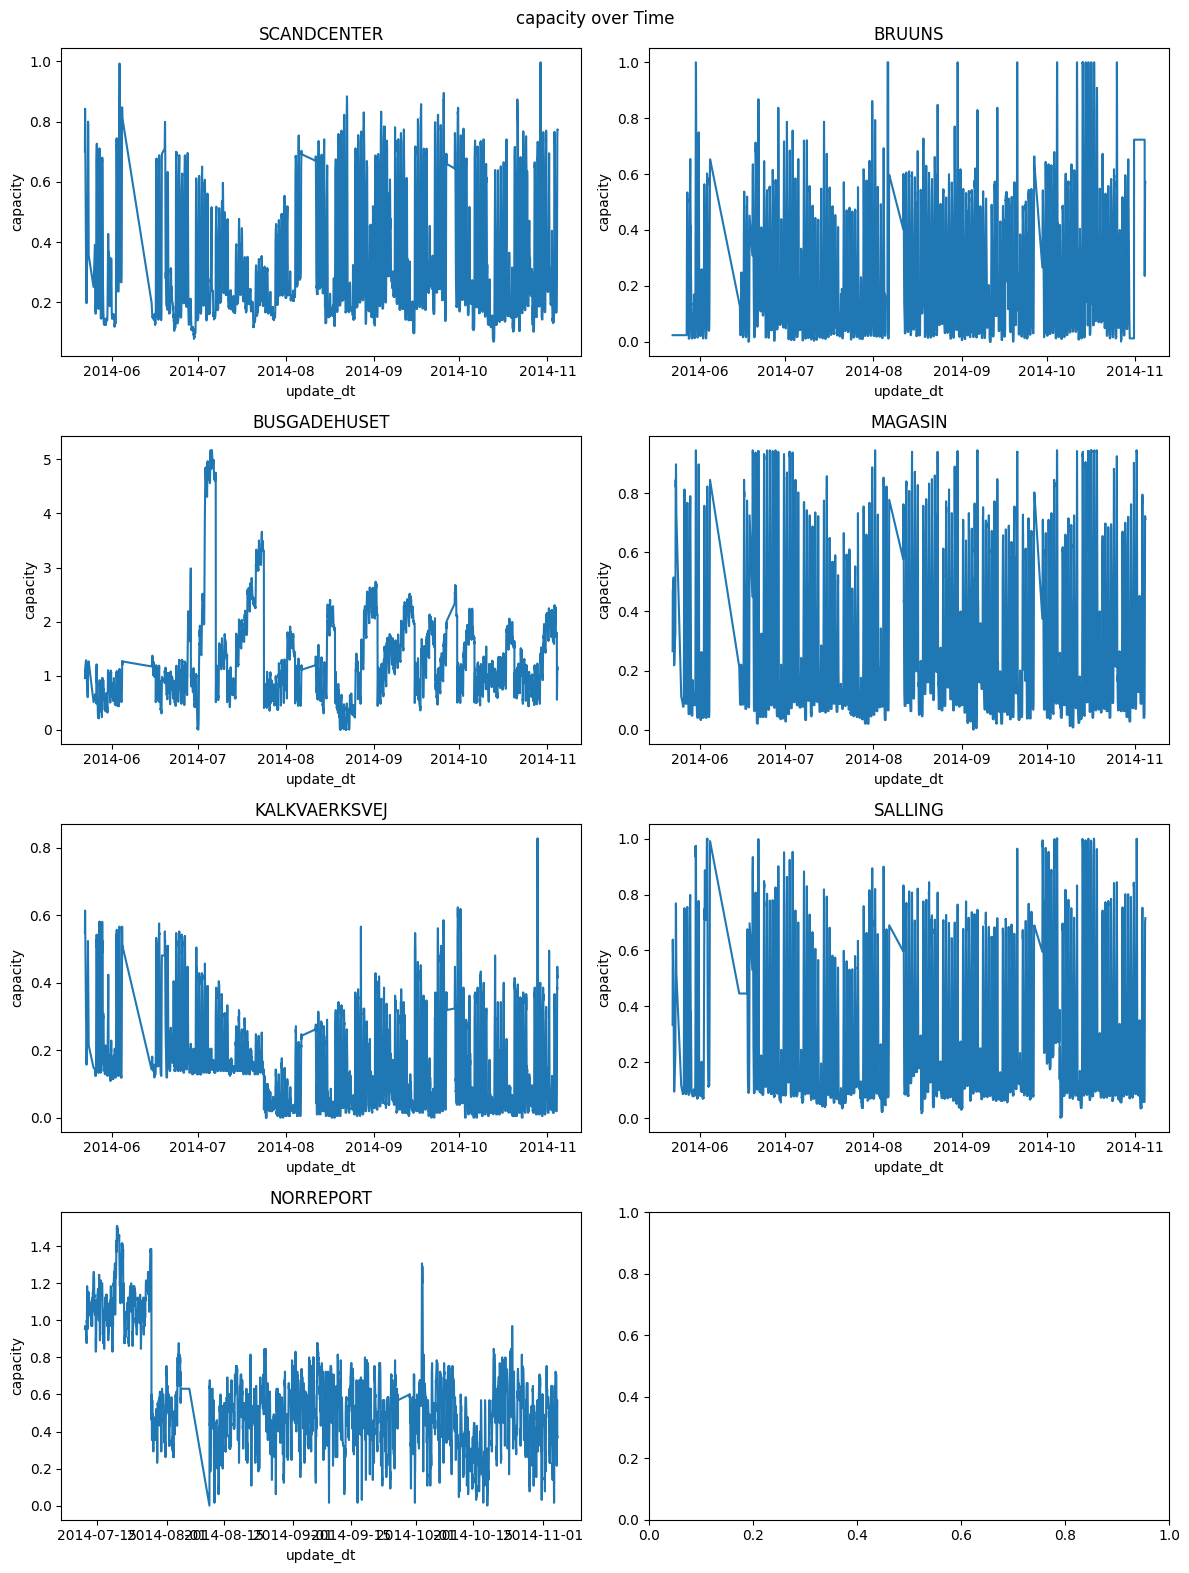

In [25]:
plot_garage_data_over_time(df, 'capacity', individual_plots=False)

Visualizing the capacity of the garages over time, the Busgadehuset garage is regularly significantly over capacity. 

In [26]:
df.to_csv('parking_data_cleaned.csv', index=False)

## Modeling prep

For modeling we will need to create sequences of data for each unique garage.  
First separate dataframes will be made for each garage. Next, each garage's dataframe can be split in to training and testing data sets (80/20). Then sequences can be made from the training and testing data.

In [27]:
# load cleaned dataset
df = pd.read_csv('parking_data_cleaned.csv')

In [28]:
# create list of individual DFs for each garage for training and testing
unique_garagecodes = df['garagecode'].unique().tolist()

train_dfs = []
test_dfs = []

train_size = .8
test_size = 1 - train_size

for garage in unique_garagecodes:
    # isolate garage
    temp_df = df[df['garagecode'] == garage]
    # split garage df into train and test
    size = len(temp_df)
    train_df = temp_df.head(int(size * train_size))
    test_df = temp_df.tail(int(size * test_size))
    # reset index
    train_df = train_df.reset_index()
    test_df = test_df.reset_index()
    # append garage dfs to master lists
    train_dfs.append(train_df)
    test_dfs.append(test_df)

In [29]:
df.columns

Index(['vehiclecount', 'totalspaces', 'garagecode', 'update_dt', 'date',
       'time', 'weekday', 'day', 'month', 'year', 'weekday_sin', 'weekday_cos',
       'month_sin', 'month_cos', 'day_sin', 'day_cos', 'time_sin', 'time_cos',
       'capacity'],
      dtype='object')

In [30]:
# create target cols list
target_cols = ['capacity']

# create feature cols list
feat_cols = df.columns
feat_cols = feat_cols.drop(['vehiclecount', 'totalspaces', 'garagecode', 'update_dt', 'date', 'time', 'weekday', 'day', 'month', 'year'])
feat_cols = feat_cols.to_list()

The parking structure updates its current vehicle count in 30 minute increments. With that in mind, the first prediction we will try to make is the parking structure capacity 30 minutes (1 time step) in the future. We will begin with using the past 5 time steps (2.5 hours) to make the prediction.

In [31]:
# training sequencing!
input_seqs = []
outputs = []

seq_length = 5
ph = 1

for df in train_dfs:
    for i in range(len(df) - seq_length - ph):
        seq = df[feat_cols].iloc[i:i+seq_length]
        target = df[target_cols].iloc[i+seq_length+ph-1]

        input_seqs.append(seq)
        outputs.append(target)

input_seqs = np.array(input_seqs, dtype=object).astype(np.float32)
outputs = np.array(outputs, dtype=object).astype(np.float32)

print(f'input data shape: {input_seqs.shape}')
print(f'target shape: {outputs.shape}')

input data shape: (37250, 5, 9)
target shape: (37250, 1)


In [32]:
outputs = outputs.reshape(-1)

In [33]:
# test data sequencing
test_seqs = []
test_outputs = []

for df in test_dfs:
    for i in range(seq_length, len(df) - ph):
        seq = df[feat_cols].iloc[i-seq_length: i]
        target = df[target_cols].iloc[i+ph-1]

        test_seqs.append(seq)
        test_outputs.append(target)

test_seqs = np.array(test_seqs, dtype=object).astype(np.float32)
test_outputs = np.array(test_outputs, dtype=object).astype(np.float32)

print(f'input data shape: {test_seqs.shape}')
print(f'target shape: {test_outputs.shape}')

input data shape: (9277, 5, 9)
target shape: (9277, 1)


In [34]:
test_outputs = test_outputs.reshape(-1)

## Modeling

Initial LSTM model:  
- LSTM (10 nodes, relu activation)
- Dropout (.2)
- LSTM (5 nodes)
- Dropout (.2)
- Dense (1)
- Optimizer: adam, loss: MSE

In [35]:
from sklearn.metrics import confusion_matrix, recall_score, precision_score
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Activation
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [36]:
model_path = 'LSTM_base_model.h5'
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0)
checkpoint = ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True, verbose=0)

model = Sequential()

model.add(LSTM( input_shape=(input_seqs.shape[1], input_seqs.shape[2]),
                units=5,
                activation='relu',
                return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM( units=5,
                activation='relu',
                return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1,
                activation='relu'))
model.compile(optimizer='adam', loss='mean_squared_error')

print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 5, 5)              300       
                                                                 
 dropout (Dropout)           (None, 5, 5)              0         
                                                                 
 lstm_1 (LSTM)               (None, 5)                 220       
                                                                 
 dropout_1 (Dropout)         (None, 5)                 0         
                                                                 
 dense (Dense)               (None, 1)                 6         
                                                                 
Total params: 526
Trainable params: 526
Non-trainable params: 0
_________________________________________________________________
None


In [37]:
epochs = 100
batch_size = 32
val_size = 0.1

In [38]:
history = model.fit(input_seqs, 
                    outputs, 
                    epochs=epochs, 
                    batch_size=batch_size, 
                    validation_split=val_size, 
                    verbose=2,
                    callbacks = [early_stopping, checkpoint])

Epoch 1/100
1048/1048 - 4s - loss: 0.1348 - val_loss: 0.0379 - 4s/epoch - 4ms/step
Epoch 2/100
1048/1048 - 2s - loss: 0.0630 - val_loss: 0.0288 - 2s/epoch - 2ms/step
Epoch 3/100
1048/1048 - 2s - loss: 0.0553 - val_loss: 0.0281 - 2s/epoch - 2ms/step
Epoch 4/100
1048/1048 - 2s - loss: 0.0506 - val_loss: 0.0241 - 2s/epoch - 2ms/step
Epoch 5/100
1048/1048 - 2s - loss: 0.0487 - val_loss: 0.0237 - 2s/epoch - 2ms/step
Epoch 6/100
1048/1048 - 2s - loss: 0.0472 - val_loss: 0.0209 - 2s/epoch - 2ms/step
Epoch 7/100
1048/1048 - 2s - loss: 0.0494 - val_loss: 0.0215 - 2s/epoch - 2ms/step
Epoch 8/100
1048/1048 - 2s - loss: 0.0463 - val_loss: 0.0215 - 2s/epoch - 2ms/step
Epoch 9/100
1048/1048 - 2s - loss: 0.0433 - val_loss: 0.0199 - 2s/epoch - 2ms/step
Epoch 10/100
1048/1048 - 2s - loss: 0.0464 - val_loss: 0.0189 - 2s/epoch - 2ms/step
Epoch 11/100
1048/1048 - 2s - loss: 0.0439 - val_loss: 0.0188 - 2s/epoch - 2ms/step
Epoch 12/100
1048/1048 - 2s - loss: 0.0430 - val_loss: 0.0189 - 2s/epoch - 2ms/step
E

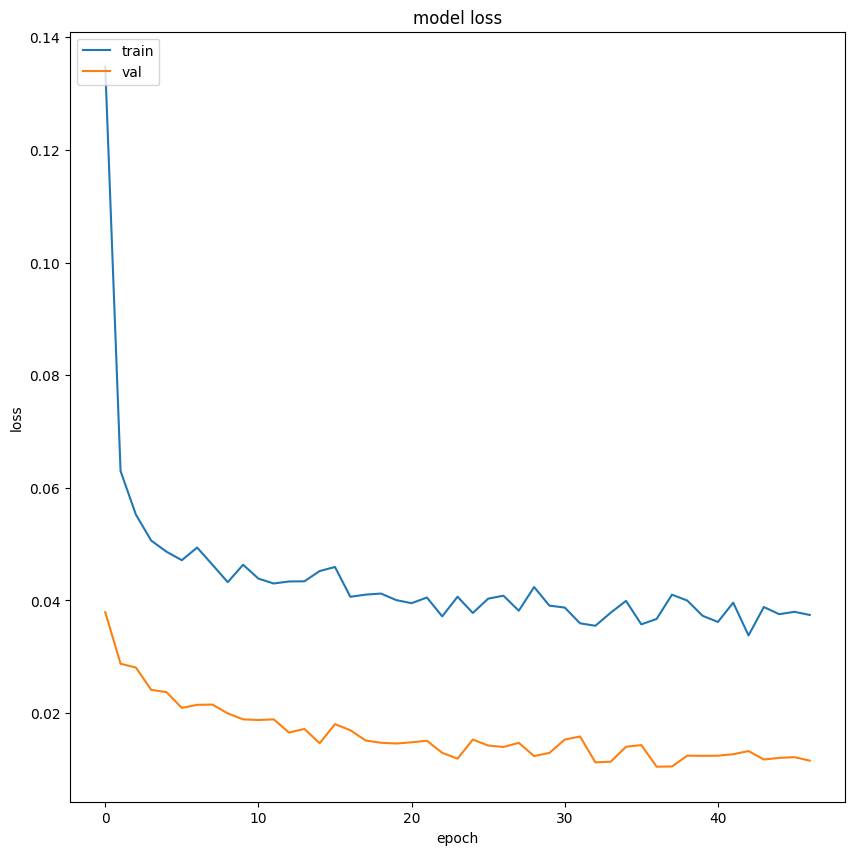

In [40]:
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [43]:
scores_test = model.evaluate(test_seqs, test_outputs, verbose=2)
print('\nMSE: {}\n'.format(scores_test))

y_pred_test = model.predict(test_seqs)
y_true_test = test_outputs

test_set = pd.DataFrame(y_pred_test)
test_set.to_csv('test_preds.csv', index = None)

290/290 - 0s - loss: 0.0151 - 261ms/epoch - 899us/step

MSE: 0.015071967616677284

290/290 [==============================] - 0s 897us/step


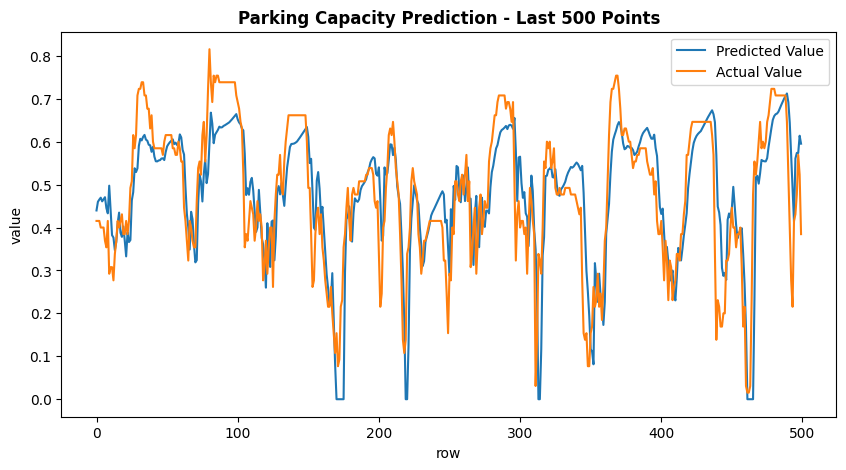

In [46]:
# Plot the predicted data vs. the actual data
# we will limit our plot to the first 500 predictions for better visualization
fig_verify = plt.figure(figsize=(10, 5))
plt.plot(y_pred_test[-500:], label = 'Predicted Value')
plt.plot(y_true_test[-500:], label = 'Actual Value')
plt.title('Parking Capacity Prediction - Last 500 Points', fontweight='bold')
plt.ylabel('value')
plt.xlabel('row')
plt.legend()
plt.show()